# Vortex dynamics

In this tutorial, we want to demonstrate how the system object can be driven using different drivers. In addition, we want to introduce some data analysis tools, which we are going to focus on in more details later. As an example, we are going to simulate vortex dynamics. More precisely, we are going to move the vortex core by applying an in-plane external magnetic field and then turn off the field and look at the vortex dynamics.

The sample is a two-dimensional square sample with $d=100 \,\text{nm}$ edge length and $5\,\text{nm}$ thickness. The material is Permalloy 

- magnetisation saturation $M_\text{s} = 8 \times 10^{5} \,\text{A}\,\text{m}^{-1}$,
- exchange energy constant $A = 13 \,\text{pJ}\,\text{m}^{-1}$,
- gyrotropic ratio $\gamma = 2.211 \times 10^{5} \,\text{m}\,\text{A}^{-1}\,\text{s}^{-1}$, and
- Gilbert damping $\alpha=0.2$.

In order to obtain the vortex state after relaxation, we have to initialise the magnetisation the right way. A state which is similar to the vortex state is:

$$(m_{x}, m_{y}, m_{z}) = (-cy, cx, 10)$$

with $c = 10^{9} \,\text{m}^{-1}$. The field we are going to apply during the relaxation is $H = 10^{4} \,\text{A}\,\text{m}^{-1}$ in the positive $x$-direction.

We start by importing necessary modules and defining parameters:

In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as mc

# Geometry
L = 100e-9  # sample edge length (m)
thickness = 5e-9  # sample thickness (nm)

# Material (permalloy) parameters
Ms = 8e5  # saturation magnetisation (A/m)
A = 13e-12  # exchange energy constant (J/m)

# Dynamics (LLG equation) parameters
gamma0 = 2.211e5  # gyromagnetic ratio (m/As)
alpha = 0.2  # Gilbert damping

Now, we can start defining our system object:

In [2]:
system = mm.System(name='vortex_dynamics')

# Energy equation
system.energy = mm.Exchange(A=A) + mm.Demag()

# Dynamics equation
system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha)

Defining the region and the mesh is relatively straightforward since the sample is cubic, but we have to initialise the magnetisation as spatially varying and we need to define a Python function for that.

In [3]:
region = df.Region(p1=(-L/2, -L/2, 0), p2=(L/2, L/2, thickness))

mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))
    
def m_init(point):
    x, y, z = point
    c = 1e9  # (1/m)
    return (-c*y, c*x, 10)

system.m = df.Field(mesh, dim=3, value=m_init, norm=Ms)

The system object is now defined and we can investigate some of its properties:

In [4]:
system.energy

Exchange(A=1.3e-11) + Demag()

In [5]:
system.dynamics

Precession(gamma0=221100.0) + Damping(alpha=0.2)

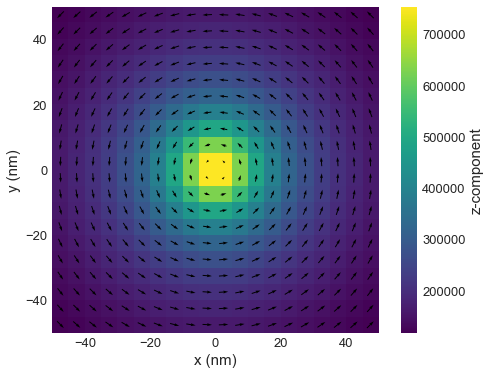

In [6]:
system.m.plane('z').mpl()

We can now relax the system.

Running OOMMF (ExeOOMMFRunner) [2021/06/25 13:21]... (1.0 s)


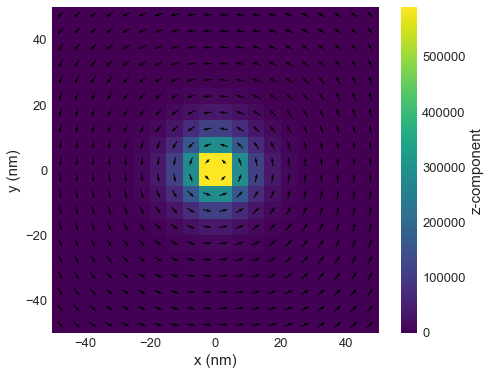

In [7]:
md = mc.MinDriver()
md.drive(system)

system.m.plane('z').mpl()

Now we have a relaxed vortex state, with its core at the centre of the sample. As the next step, we want to add an external magnetic field in the positive $x$-direction and hope to move the vortex core.

Running OOMMF (ExeOOMMFRunner) [2021/06/25 13:21]... (1.2 s)


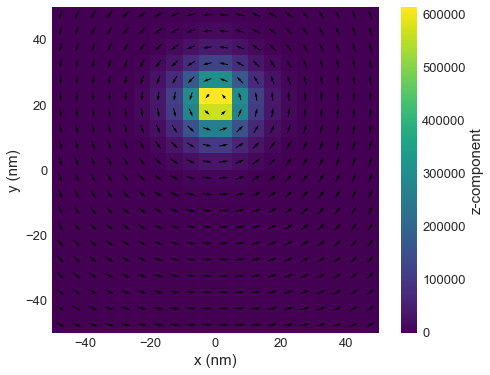

In [8]:
H = (1e4, 0, 0)  # an external magnetic field (A/m)

system.energy += mm.Zeeman(H=H)

md.drive(system)
system.m.plane('z').mpl()

The vortex core is now moved in the positive $y$-direction. As the last step, we are going to turn off the field and simulate dynamics using `TimeDriver`. We are going to simulate for $5\,\text{ns}$ and save the magnetisation in $500$ steps.

In [9]:
system.energy.zeeman.H = (0, 0, 0)

td = mc.TimeDriver()
td.drive(system, t=5e-9, n=500)

Running OOMMF (ExeOOMMFRunner) [2021/06/25 13:22]... (6.6 s)


After the simulation finishes, we can plot the final magnetisation state:

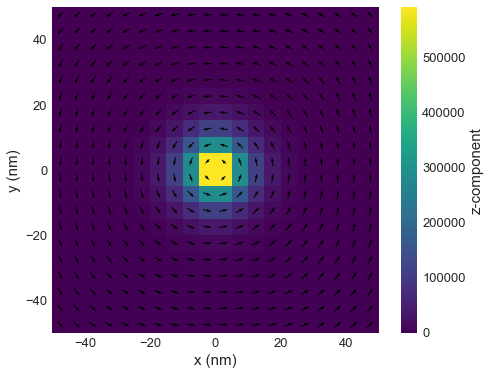

In [10]:
system.m.plane('z').mpl()

The table with scalar data collected during the simulation is:

In [11]:
system.m

Field(mesh=Mesh(region=Region(p1=(-5e-08, -5e-08, 0.0), p2=(5e-08, 5e-08, 5e-09)), n=(20, 20, 1), bc='', subregions={}), dim=3)

In [12]:
system.table.data

,E,E_calc_count,max_dm/dt,dE/dt,delta_E,E_exchange,max_spin_ang_exchange,stage_max_spin_ang_exchange,run_max_spin_ang_exchange,E_demag,E_zeeman,iteration,stage_iteration,stage,mx,my,mz,last_time_step,t
0,1.853703e-18,43.0,233.280575,-2.052828e-10,-2.314959e-22,1.326230e-18,57.808185,58.126415,58.126415,5.274725e-19,0.0,6.0,6.0,0.0,0.351628,0.000734,0.023158,1.179228e-12,1.000000e-11
1,1.850967e-18,80.0,381.443970,-3.279214e-10,-5.165182e-22,1.333487e-18,58.286517,58.286517,58.286517,5.174800e-19,0.0,12.0,5.0,1.0,0.335981,0.002518,0.023064,1.606460e-12,2.000000e-11
2,1.847516e-18,117.0,510.874951,-3.449882e-10,-3.011571e-22,1.342260e-18,59.576209,59.576209,59.576209,5.052563e-19,0.0,19.0,6.0,2.0,0.318457,0.005884,0.022817,8.697766e-13,3.000000e-11
3,1.844316e-18,154.0,599.686452,-2.882586e-10,-2.459911e-22,1.349227e-18,60.742973,60.742973,60.742973,4.950894e-19,0.0,26.0,6.0,3.0,0.303181,0.010941,0.022385,8.443676e-13,4.000000e-11
4,1.841802e-18,191.0,676.446501,-2.159121e-10,-2.092769e-22,1.352728e-18,61.359905,61.359905,61.359905,4.890731e-19,0.0,33.0,6.0,4.0,0.292161,0.017440,0.021858,9.549189e-13,5.000000e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.765512e-18,18364.0,1.354777,-1.013063e-15,-1.061038e-27,1.365677e-18,57.084570,57.084747,62.059729,3.998347e-19,0.0,3470.0,6.0,495.0,-0.000059,-0.000246,0.022938,9.864553e-13,4.960000e-09
496,1.765512e-18,18401.0,1.331959,-9.658813e-16,-1.008047e-27,1.365677e-18,57.083946,57.084570,62.059729,3.998347e-19,0.0,3477.0,6.0,496.0,-0.000038,-0.000244,0.022938,9.829044e-13,4.970000e-09
497,1.765512e-18,18438.0,1.311606,-9.231589e-16,-9.606878e-28,1.365677e-18,57.082998,57.083946,62.059729,3.998347e-19,0.0,3484.0,6.0,497.0,-0.000017,-0.000241,0.022938,9.790903e-13,4.980000e-09
498,1.765512e-18,18475.0,1.287092,-8.816371e-16,-9.196202e-28,1.365677e-18,57.081626,57.082998,62.059729,3.998346e-19,0.0,3491.0,6.0,498.0,0.000002,-0.000236,0.022938,9.803731e-13,4.990000e-09


Now, let us plot the average $x$ and $y$ components of magnetisation as a function of time, which gives us a rough idea of the vortex core position. To do that, we call the `mpl` method of the table object and pass `y` list of columns we want to plot. The details of plotting scalar data will be covered later, when we focus on data analysis and visualisation.  

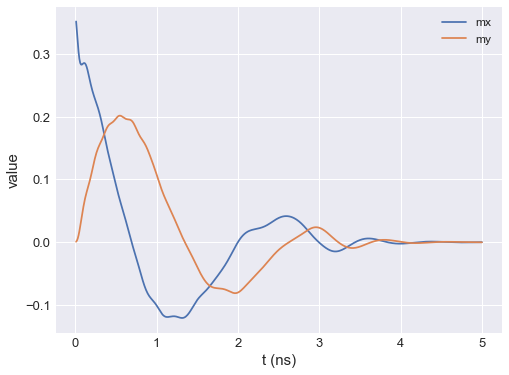

In [14]:
system.table.mpl(y=['mx', 'my'])

In [18]:
import ubermag
ubermag.__version__

'0.51'

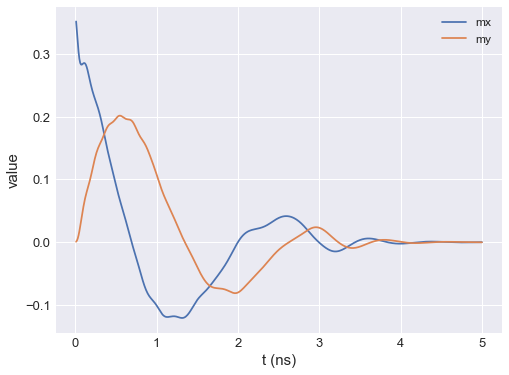

In [20]:
system.table.mpl(y=['mx', 'my'])

Finally, we are going to have a look at the magnetisation field at different time steps. For that, we are going to use `micromagneticdata` module. We introduce some basics here, but the details will be covered later. The main object is `Data` which requires us to pass the name we used when we created the system object.

In [14]:
import micromagneticdata as md

data = md.Data(system.name)

After the data object is created, we can investigate what drives we did so far:

In [15]:
data.info

,drive_number,date,time,driver,t,n
0,0,2021-01-04,11:03:25,MinDriver,NaN,NaN
1,1,2021-01-04,11:03:27,MinDriver,NaN,NaN
2,2,2021-01-04,11:03:28,TimeDriver,5.000000e-09,500.0
3,3,2021-01-04,11:06:15,MinDriver,NaN,NaN
4,4,2021-01-04,11:06:17,MinDriver,NaN,NaN
5,5,2021-01-04,11:06:18,TimeDriver,5.000000e-09,500.0


We are interested in the last drive with index 2. To get that drive from the data, we use `[]` operator from the data object.

Now, we can plot the magnetisation at, for example, 200th step, as

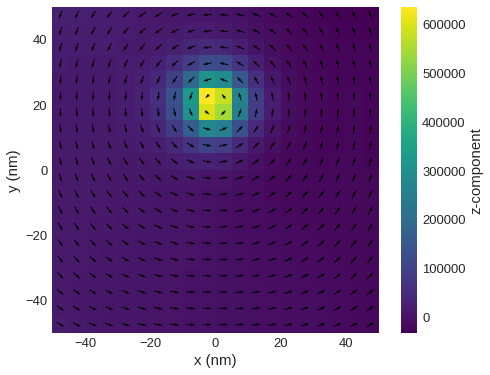

In [16]:
data[-1][1].plane('z').mpl()

In [17]:
@df.interact(n=data[-1].slider())
def my_plot(n):
    data[-1][n].plane('z').mpl()

interactive(children=(IntSlider(value=0, description='step', max=499), Output()), _dom_classes=('widget-intera…

Let us now try to make our plot interactive, which is again going to be the topic of another session.

In [18]:
@df.interact(nstep=data[-1].slider(continuous_update=False))
def our_interactive_plot(nstep):
    data[-1][nstep].plane('z').mpl()

interactive(children=(IntSlider(value=0, continuous_update=False, description='step', max=499), Output()), _do…

We get a widget assigned to the plot, so we can interactively invetsigate the magentisation dynamics. As the last step, we can delete the directory created by ubermag:

In [19]:
# mc.delete(system)